In [1]:
import numpy as np
import matplotlib.pyplot as plt
import burst_detector as bd
import seaborn as sns
from scipy.stats import wasserstein_distance
import pandas as pd

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
n_chan = 385
times = np.load('../data/neuropixels_dohoung/KS2.5/phy_in/spike_times.npy').flatten()
clusters = np.load('../data/neuropixels_dohoung/KS2.5/phy_in/spike_clusters.npy').flatten()
mean_wf = np.load("../data/neuropixels_dohoung/KS2.5/phy_in/mean_waveforms.npy")

counts = bd.spikes_per_cluster(clusters)
labels = pd.read_csv("../data/neuropixels_dohoung/KS2.5/phy_in/cluster_group.tsv", sep="\t")

In [3]:
# load raw data
rawData = np.memmap("../data/neuropixels_dohoung/KS2.5/catgt_ANM480363_20210527_pfc320_hpc180_g0/ANM480363_20210527_pfc320_hpc180_g0_imec1/ANM480363_20210527_pfc320_hpc180_g0_tcat.imec1.ap.bin", dtype='int16', mode='r')
data = np.reshape(rawData, (int(rawData.size/n_chan), n_chan))

In [4]:
mean_wf.shape

(165, 385, 82)

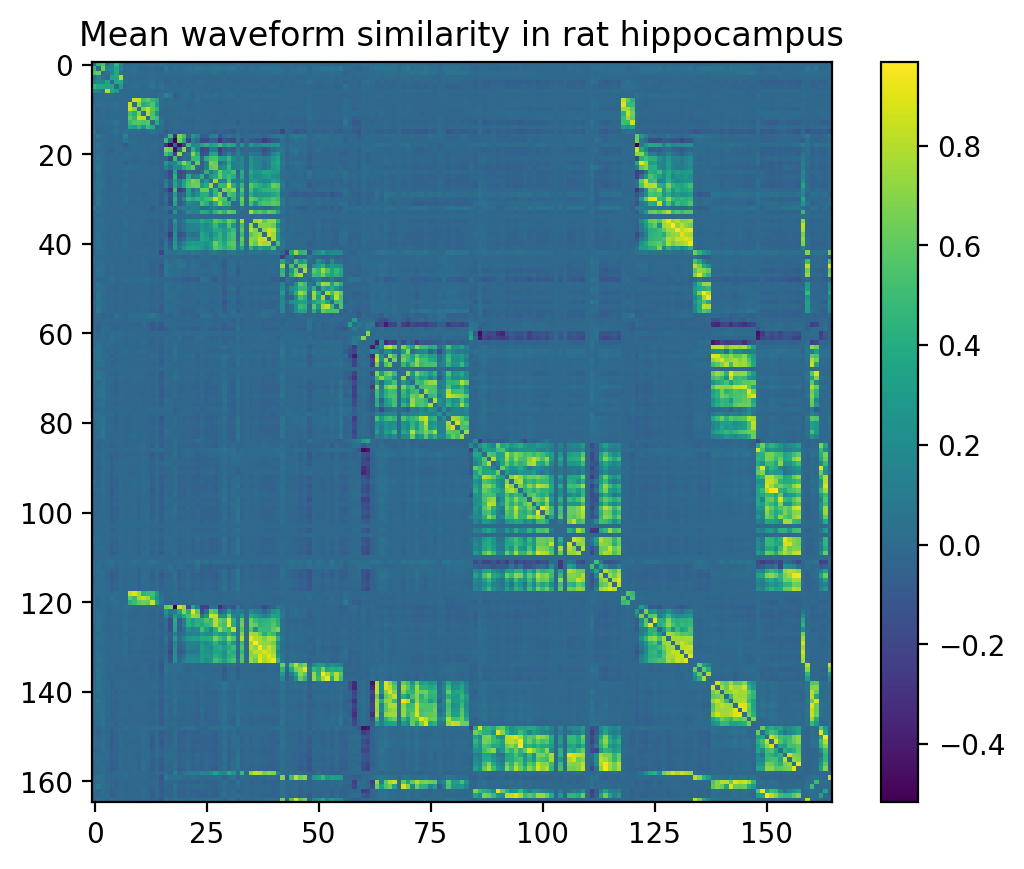

In [5]:
mean_sim, wf_means_norm = bd.wf_means_similarity(mean_wf)
plt.imshow(mean_sim)
plt.colorbar(); plt.title("Mean waveform similarity in rat hippocampus");

In [7]:
n_clust = 165
offsets = np.zeros((n_clust))

for i in range(n_clust):
    if labels.iloc[i]['group']=='good':
        offsets[i] = np.unravel_index(np.argmin(mean_wf[i,:,:25]),wf_means_norm[i,:,:25].shape)[1]

In [7]:
sim_thresh = 0.4
sp_num_thresh = 100

In [133]:
# params for merge candidates
num  = 0
wass_d = np.ones_like(mean_sim)
for c1 in range(counts.shape[0]):
    for c2 in range(c1+1, counts.shape[0]):
        
        # keep similar cluster pairs where both have sufficient spikes and are not noise
        if mean_sim[c1,c2] >= sim_thresh and (counts[c1] >= sp_num_thresh) and (counts[c2] >= sp_num_thresh):
            if (labels.iloc[c1]['group'] == 'good') and (labels.iloc[c2]['group'] == 'good'):
                
                # extract spikes
                sp_1 = bd.extract_spikes(data, times, clusters, c1)
                sp_2 = bd.extract_spikes(data, times, clusters, c2)
                
                # compute cross-projections
                proj_1on1, proj_2on1, proj_1on2, proj_2on2 = bd.cross_proj(sp_1, sp_2, wf_means_norm[c1], wf_means_norm[c2])
                
                # compute wasserstein distances
                wass_d[c1, c2] = wasserstein_distance(proj_1on1/proj_1on1, proj_1on2/proj_1on1)
                wass_d[c2, c1] = wasserstein_distance(proj_2on2/proj_2on2, proj_2on1/proj_2on2)
                
                num += 1
                if (num % 10 == 0):
                    print("finished pair %d" % num)
                    
np.save("hippo_wass_d.npy", wass_d)

finished pair 10
finished pair 20
finished pair 30
finished pair 40
finished pair 50
finished pair 60
finished pair 70
finished pair 80
finished pair 90
finished pair 100
finished pair 110
finished pair 120
finished pair 130
finished pair 140
finished pair 150
finished pair 160
finished pair 170
finished pair 180
finished pair 190
finished pair 200
finished pair 210
finished pair 220
finished pair 230
finished pair 240
finished pair 250
finished pair 260
finished pair 270
finished pair 280
finished pair 290
finished pair 300
finished pair 310
finished pair 320
finished pair 330
finished pair 340
finished pair 350
finished pair 360
finished pair 370
finished pair 380
finished pair 390
finished pair 400
finished pair 410
finished pair 420
finished pair 430
finished pair 440
finished pair 450
finished pair 460
finished pair 470
finished pair 480
finished pair 490
finished pair 500
finished pair 510
finished pair 520
finished pair 530


In [9]:
wass_d = np.load("hippo_wass_d.npy")

In [36]:
pass_1 = np.zeros_like(mean_sim, dtype='bool')
for c1 in range(counts.shape[0]): 
    for c2 in range(c1+1, counts.shape[0]):
        
        # keep similar cluster pairs where both have sufficient spikes and are not noise
        if mean_sim[c1,c2] >= sim_thresh and (counts[c1] >= sp_num_thresh) and (counts[c2] >= sp_num_thresh):
            if (labels.iloc[c1]['group'] == 'good') and (labels.iloc[c2]['group'] == 'good'):
                pass_1[c1,c2] = True
                pass_1[c2,c1] = True

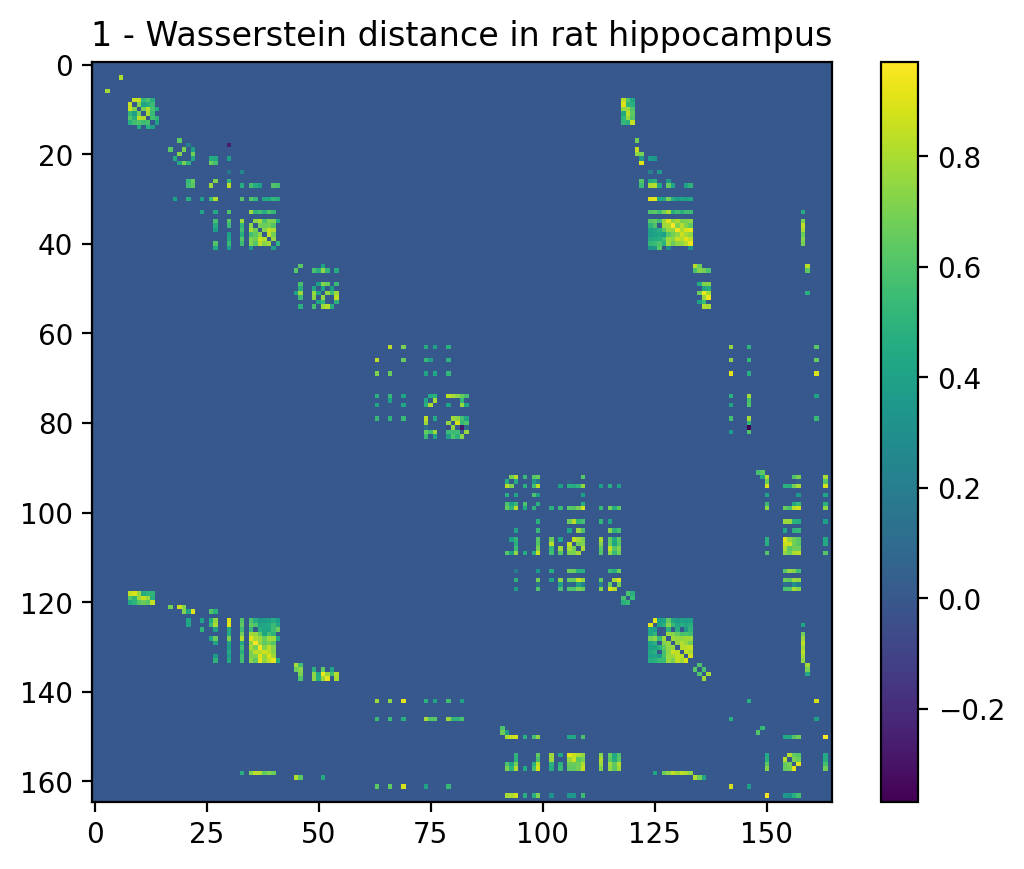

In [10]:
plt.imshow(1-wass_d)
plt.colorbar(); plt.title("1 - Wasserstein distance in rat hippocampus");

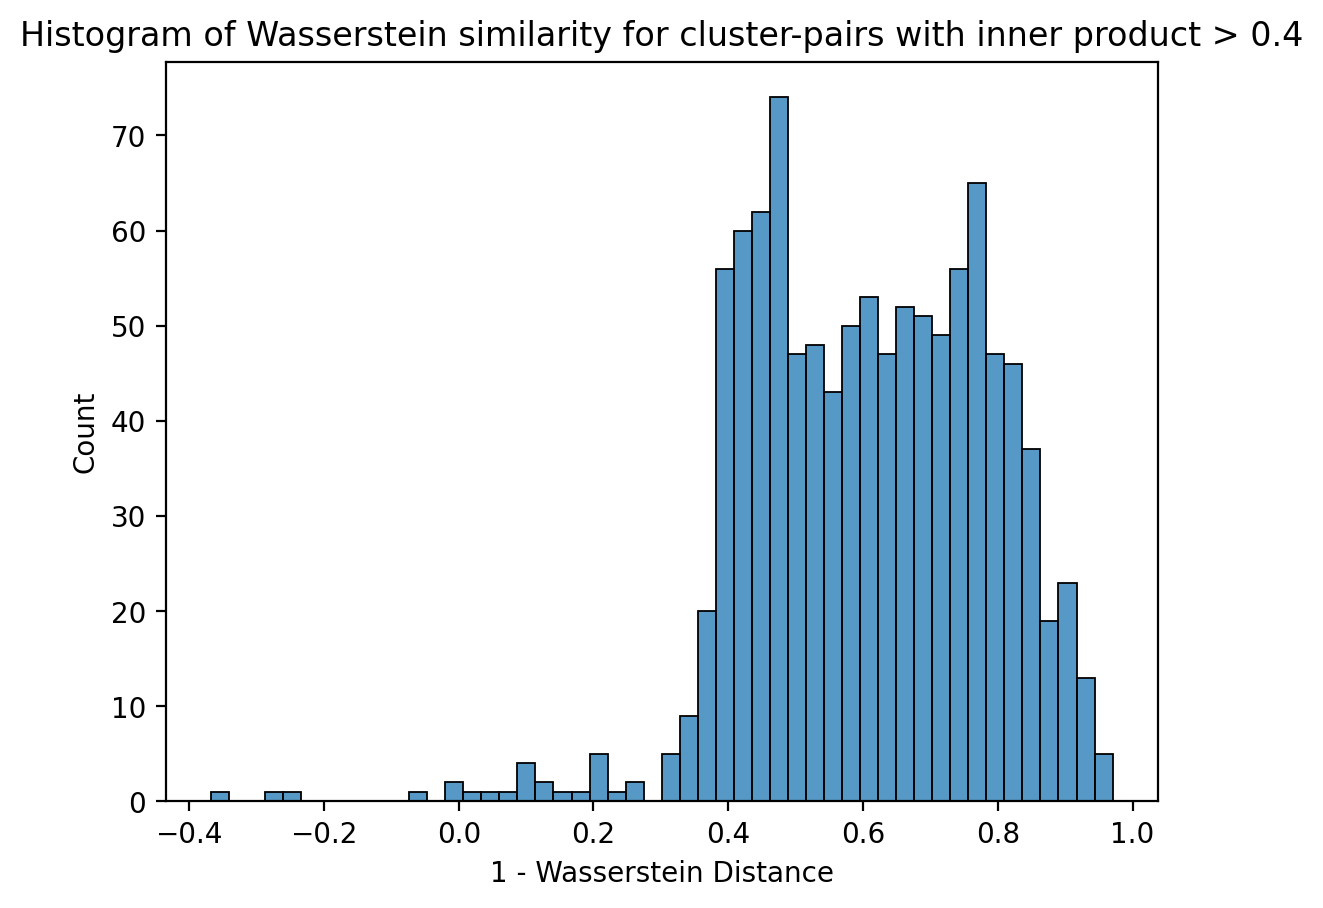

In [40]:
sns.histplot(wass_sim.flatten()[pass_1.flatten()], bins=50);

plt.xlabel("1 - Wasserstein Distance");
plt.title("Histogram of Wasserstein similarity for cluster-pairs with inner product > 0.4");

In [64]:
wass_sim = 1-wass_d

merge_dec = np.zeros_like(mean_sim)
wass_thresh = 0.75
num = 0

for c1 in range(counts.shape[0]): 
    for c2 in range(c1+1, counts.shape[0]):
        
        # keep similar cluster pairs where both have sufficient spikes and are not noise
        if mean_sim[c1,c2] >= sim_thresh and (counts[c1] >= sp_num_thresh) and (counts[c2] >= sp_num_thresh):
            if (labels.iloc[c1]['group'] == 'good') and (labels.iloc[c2]['group'] == 'good'):
                if (wass_sim[c1, c2] > wass_thresh) and (wass_sim[c2, c1] > wass_thresh):
                    merge_dec[c1, c2] = 1
                    merge_dec[c2, c1] = 1                

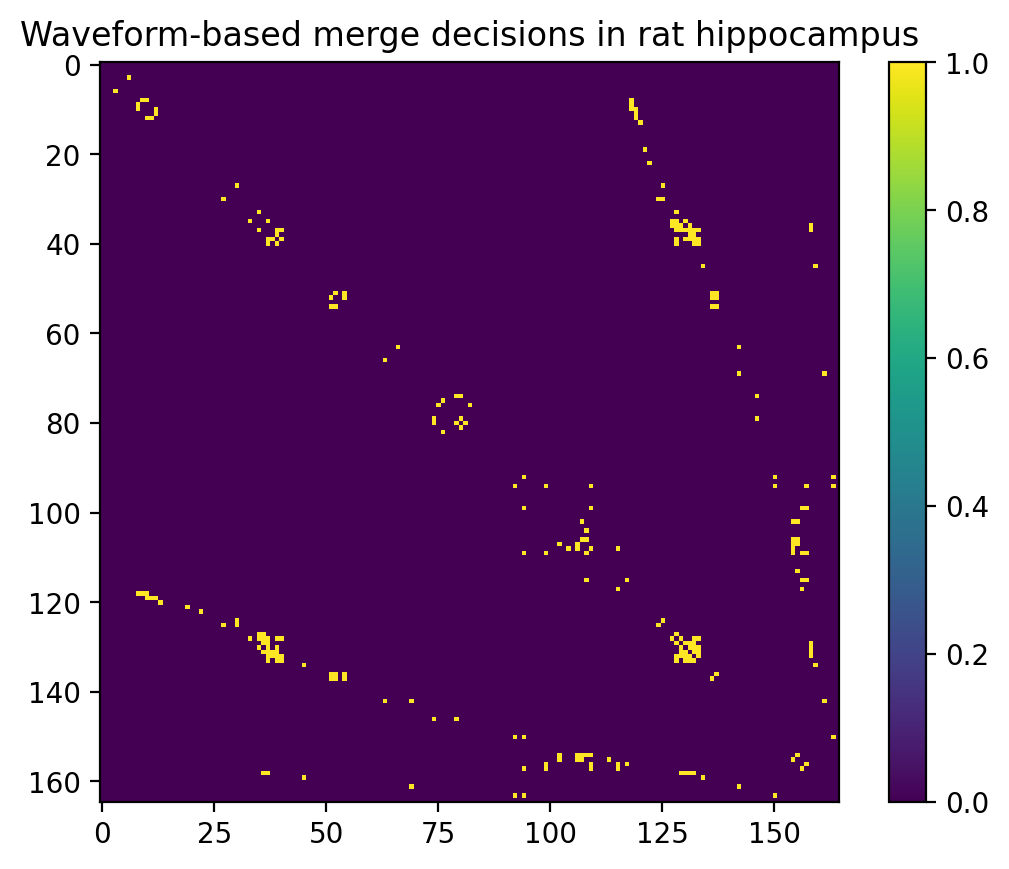

In [65]:
plt.imshow(merge_dec)
plt.colorbar();
plt.title("Waveform-based merge decisions in rat hippocampus");

In [15]:
# params for merge candidates
num  = 0
xcorr_sig = np.zeros_like(mean_sim)
for c1 in range(counts.shape[0]):
    for c2 in range(c1+1, counts.shape[0]):
        
        # keep similar cluster pairs where both have sufficient spikes and are not noise
        if mean_sim[c1,c2] >= sim_thresh and (counts[c1] >= sp_num_thresh) and (counts[c2] >= sp_num_thresh):
            if (labels.iloc[c1]['group'] == 'good') and (labels.iloc[c2]['group'] == 'good'):
                
                # extract spike times
                cl_times = bd.find_times_multi(times/30000, clusters, [c1, c2])
                c1_times = cl_times[0]
                c2_times = cl_times[1]
                
                # compute significance
                sig = bd.xcorr_sig(c1_times, c2_times)
                
                # compute wasserstein distances
                xcorr_sig[c1, c2] = sig
                xcorr_sig[c2, c1] = sig
                
                num += 1
                if (num % 10 == 0):
                    print("finished pair %d" % num)

finished pair 10
finished pair 20
finished pair 30
finished pair 40
finished pair 50
finished pair 60
finished pair 70
finished pair 80
finished pair 90
finished pair 100
finished pair 110
finished pair 120
finished pair 130
finished pair 140
finished pair 150
finished pair 160
finished pair 170
finished pair 180
finished pair 190
finished pair 200
finished pair 210
finished pair 220
finished pair 230
finished pair 240
finished pair 250
finished pair 260
finished pair 270
finished pair 280
finished pair 290
finished pair 300
finished pair 310
finished pair 320
finished pair 330
finished pair 340
finished pair 350
finished pair 360
finished pair 370
finished pair 380
finished pair 390
finished pair 400
finished pair 410
finished pair 420
finished pair 430
finished pair 440
finished pair 450
finished pair 460
finished pair 470
finished pair 480
finished pair 490
finished pair 500
finished pair 510
finished pair 520
finished pair 530


In [30]:
xcorr_sig = np.load("hippo_xcorr_sig.npy")

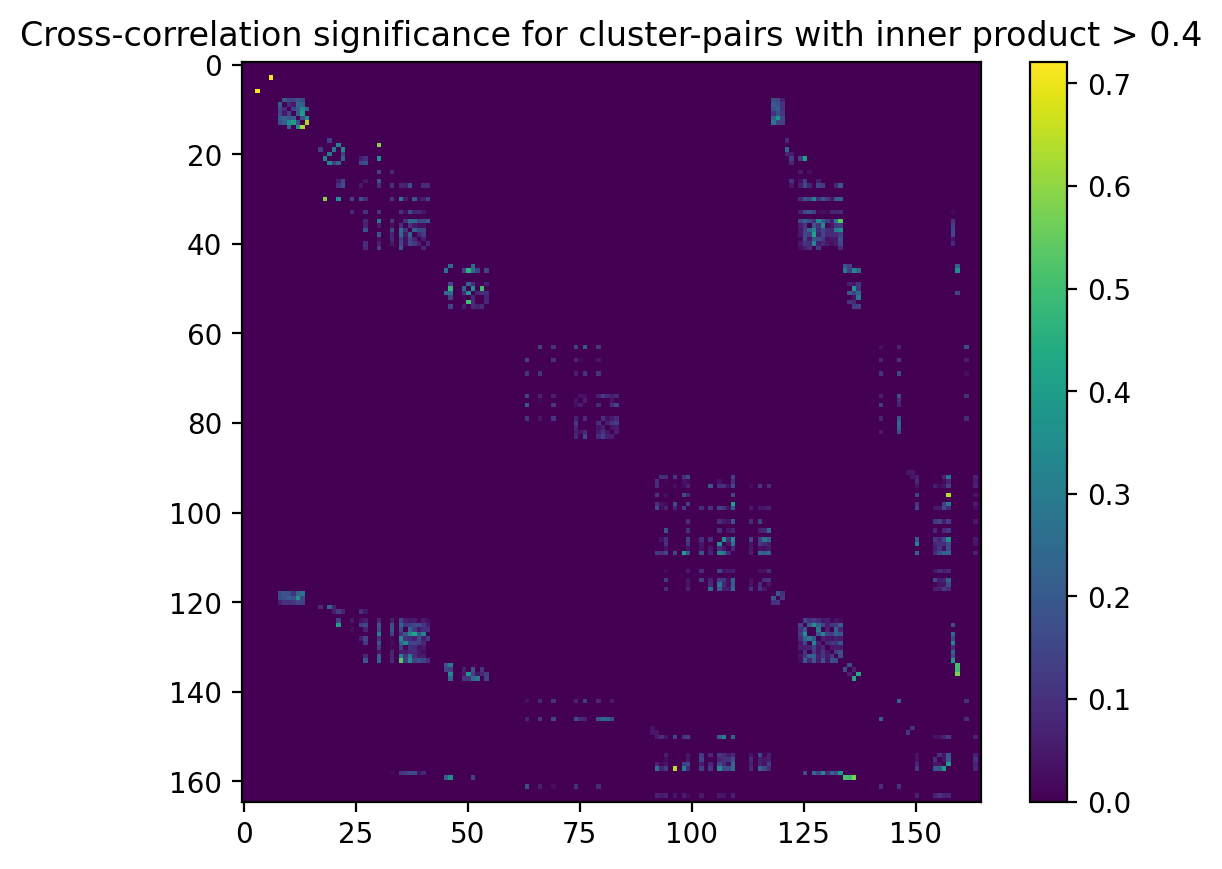

In [52]:
plt.imshow(xcorr_sig); plt.colorbar();
plt.title("Cross-correlation significance for cluster-pairs with inner product > 0.4");

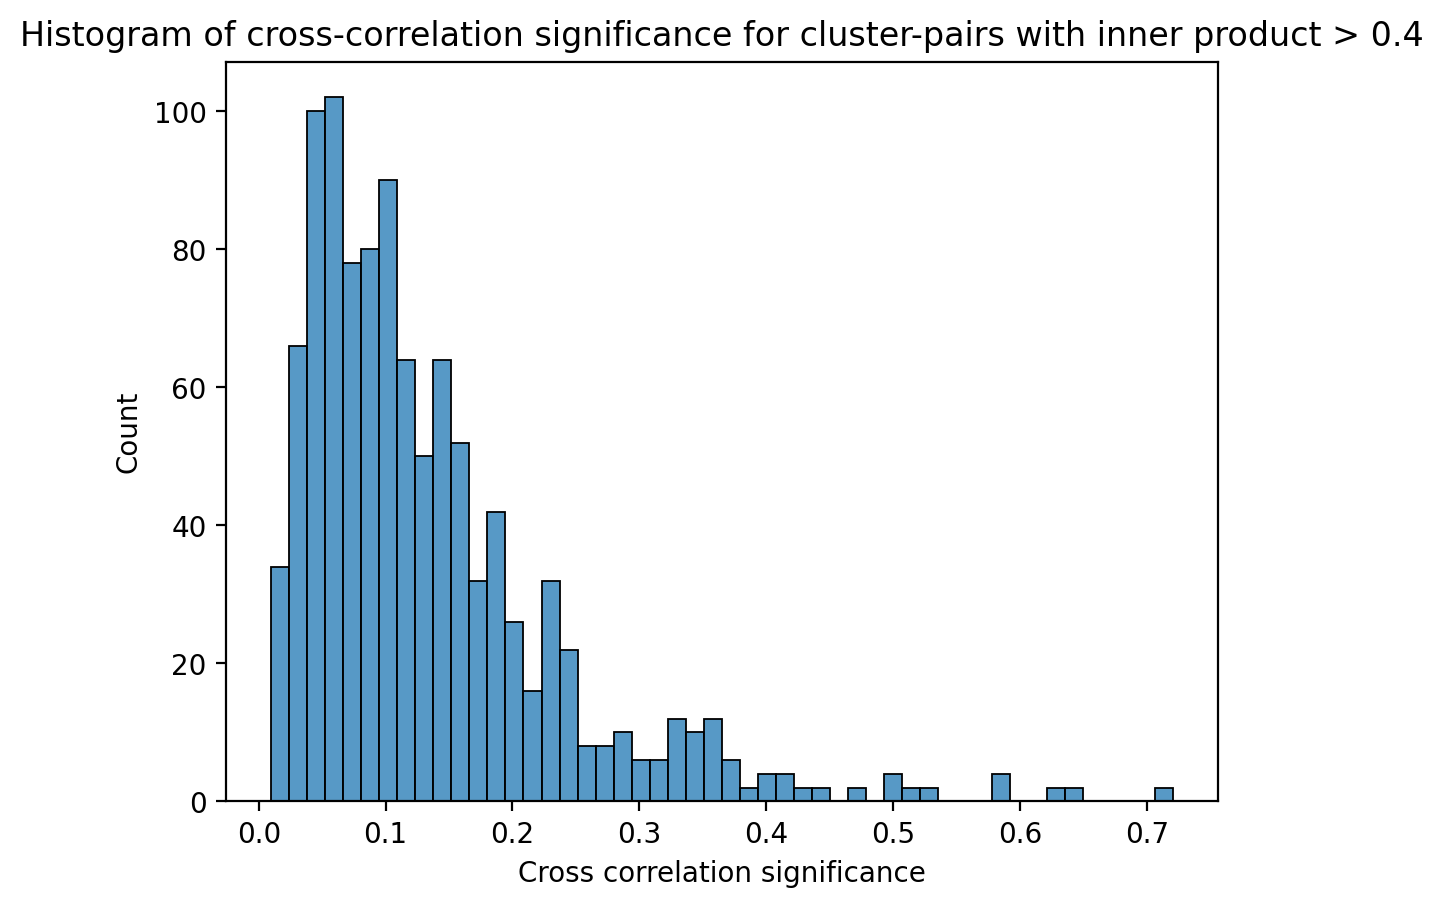

In [41]:
sns.histplot(xcorr_sig.flatten()[pass_1.flatten()], bins=50);

plt.xlabel("Cross correlation significance");
plt.title("Histogram of cross-correlation significance for cluster-pairs with inner product > 0.4");

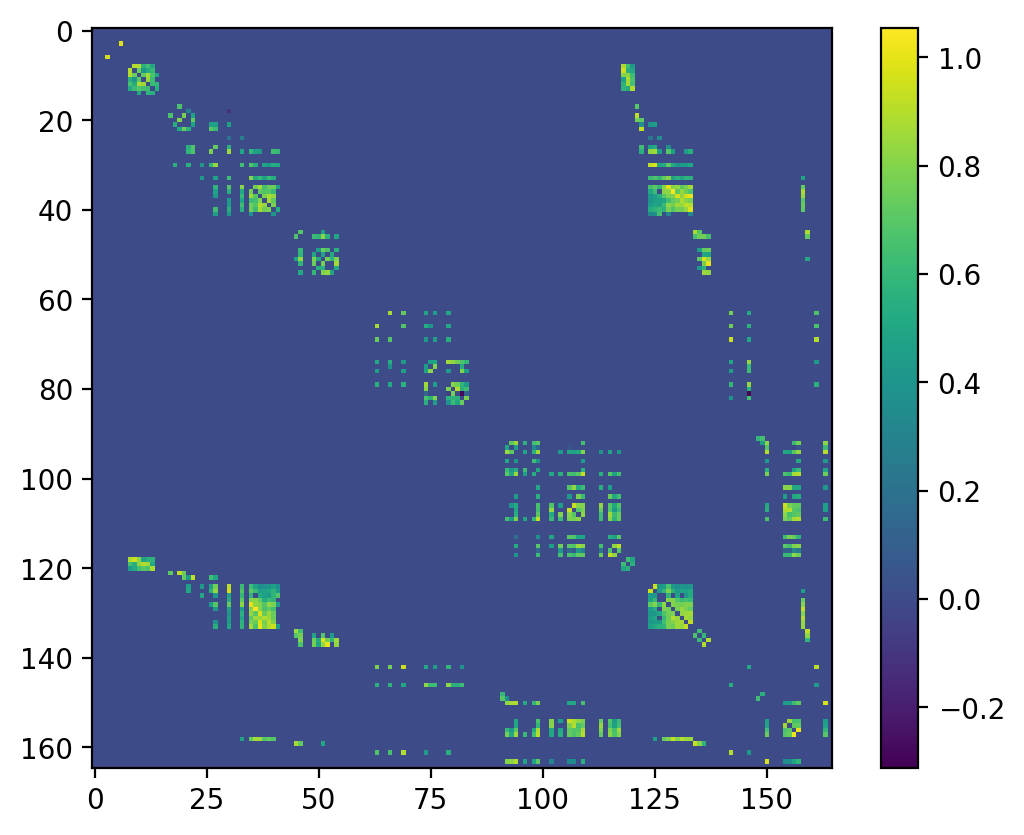

In [48]:
plt.imshow((1-wass_d + .25 * xcorr_sig));
plt.colorbar(); 

In [57]:
merge_dec_all = np.zeros_like(mean_sim)
wass_thresh = 0.75
num = 0
metric = 1-wass_d + .25 * xcorr_sig

for c1 in range(counts.shape[0]): 
    for c2 in range(c1+1, counts.shape[0]):
        
        # keep similar cluster pairs where both have sufficient spikes and are not noise
        if pass_1[c1,c2] == True:
                if (metric[c1, c2] > wass_thresh) and (metric[c2, c1] > wass_thresh):
                    merge_dec_all[c1, c2] = 1
                    merge_dec_all[c2, c1] = 1                

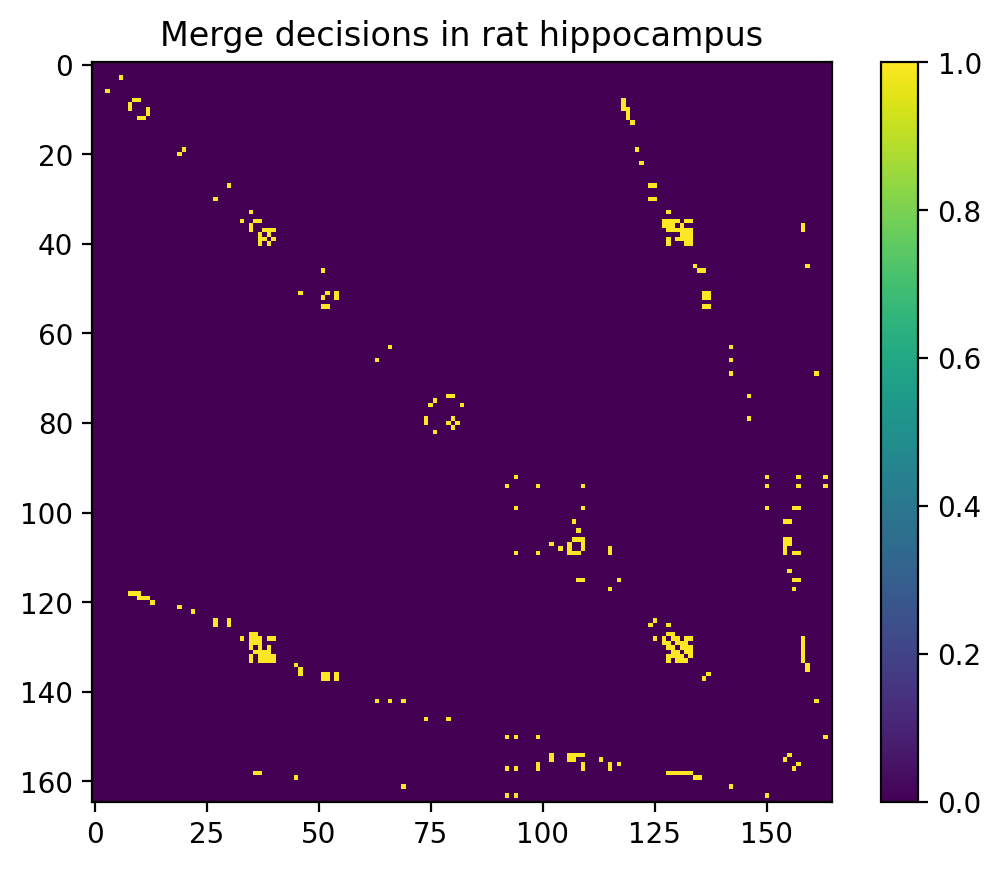

In [58]:
plt.imshow(merge_dec_all)
plt.colorbar();
plt.title("Merge decisions in rat hippocampus");